In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import mdtraj as md

import torch

from snrv import Snrv

In [2]:
traj = md.load("../traj_2000_2500.dcd", top="../aib9.gro")
biasing_atom_ids = np.array([atom.index for atom in traj.topology.atoms if atom.residue.name != 'HOH'])
feat_indices = np.array([atom.index for atom in traj.topology.atoms if (atom.name == 'CA' or atom.name == 'CAY' or atom.name == 'CAT')])
pos = torch.from_numpy(traj.xyz)
box = torch.from_numpy(np.asarray([np.diag(i) for i in traj.unitcell_vectors])).view(-1, 1, 3)

In [3]:
def generate_pair_indices_from_list(index_list):
    i_list = []
    j_list = []
    for i in range(len(index_list)):
        for j in range(i + 1, len(index_list)):
            i_list.append(index_list[i])
            j_list.append(index_list[j])
    return torch.tensor(i_list), torch.tensor(j_list)

In [4]:
i_list_d, j_list_d = generate_pair_indices_from_list(feat_indices)

In [5]:
def compute_mic_dist(pos, box, i, j):
    d = pos[:, i, :] - pos[:, j, :]  # shape: [T, M, 3]
    d = d - box * torch.round(d / box)  # apply MIC
    return torch.norm(d, dim=-1)  # shape: [T, M]

In [6]:
traj_x_d = compute_mic_dist(pos, box, i_list_d, j_list_d)

In [7]:
def generate_dihedral_indices_linear(index_list):
    i_list = []
    j_list = []
    k_list = []
    l_list = []

    for n in range(len(index_list) - 3):
        i_list.append(index_list[n])
        j_list.append(index_list[n + 1])
        k_list.append(index_list[n + 2])
        l_list.append(index_list[n + 3])

    return (
        torch.tensor(i_list, dtype=torch.long),
        torch.tensor(j_list, dtype=torch.long),
        torch.tensor(k_list, dtype=torch.long),
        torch.tensor(l_list, dtype=torch.long),
    )

In [8]:
i_list_dih, j_list_dih, k_list_dih, l_list_dih = generate_dihedral_indices_linear(feat_indices)

In [9]:
def compute_mic_dihedrals(pos, box, i, j, k, l):
    # pos: [T, N, 3]
    # box: [T, 1, 3] (broadcastable)
    # i, j, k, l: [M]

    # MIC vectors
    b1 = pos[:, j, :] - pos[:, i, :]
    b1 = b1 - box * torch.round(b1 / box)

    b2 = pos[:, k, :] - pos[:, j, :]
    b2 = b2 - box * torch.round(b2 / box)

    b3 = pos[:, l, :] - pos[:, k, :]
    b3 = b3 - box * torch.round(b3 / box)

    # Normalize b2 for later
    b2_norm = torch.nn.functional.normalize(b2, dim=-1)

    # Compute normals to the planes
    n1 = torch.cross(b1, b2, dim=-1)  # plane i-j-k
    n2 = torch.cross(b2, b3, dim=-1)  # plane j-k-l

    # Normalize
    n1 = torch.nn.functional.normalize(n1, dim=-1)
    n2 = torch.nn.functional.normalize(n2, dim=-1)

    # Compute cosine and sine terms
    cos_phi = (n1 * n2).sum(dim=-1).clamp(-1.0, 1.0)
    sin_phi = (torch.cross(n1, n2, dim=-1) * b2_norm).sum(dim=-1)

    # Final torsion angle
    dihedrals = torch.atan2(sin_phi, cos_phi)  # shape: [T, M], radians

    return dihedrals

In [10]:
traj_x_dih = compute_mic_dihedrals(pos, box, i_list_dih, j_list_dih, k_list_dih, l_list_dih)

In [11]:
traj_x = torch.concat([traj_x_d, traj_x_dih], dim=1)

In [12]:
traj_x.shape

torch.Size([10000, 63])

In [13]:
input_size = traj_x.size()[1]
output_size = 3
hidden_depth = 3
hidden_size = 500
batch_norm = True
dropout_rate = 0.
lr = 1E-5
weight_decay = 0.
val_frac = 0.20
n_epochs = 75
batch_size = 500
VAMPdegree = 2
is_reversible = True
num_workers = 0

model = Snrv(input_size, output_size, hidden_depth=hidden_depth, hidden_size=hidden_size,
            batch_norm=batch_norm, dropout_rate=dropout_rate, lr=lr, weight_decay=weight_decay, 
            val_frac=val_frac, n_epochs=n_epochs, batch_size=batch_size, 
            VAMPdegree=VAMPdegree, is_reversible=is_reversible, num_workers=num_workers, device="cuda")
model = model.to("cuda")

In [14]:
lag = 1
model.fit(traj_x, lag)
model.save_model(f'snrv_{lag}.pt')

Epoch 0: 100%|██████████| 16/16 [00:00<00:00, 31.98batch/s]


[Epoch 0]	 training loss = -1.491	 validation loss = -1.545


Epoch 1: 100%|██████████| 16/16 [00:00<00:00, 96.10batch/s]


[Epoch 1]	 training loss = -1.704	 validation loss = -1.695


Epoch 2: 100%|██████████| 16/16 [00:00<00:00, 95.66batch/s]


[Epoch 2]	 training loss = -1.858	 validation loss = -1.826


Epoch 3: 100%|██████████| 16/16 [00:00<00:00, 99.40batch/s] 


[Epoch 3]	 training loss = -1.995	 validation loss = -1.957


Epoch 4: 100%|██████████| 16/16 [00:00<00:00, 94.77batch/s]


[Epoch 4]	 training loss = -2.122	 validation loss = -2.087


Epoch 5: 100%|██████████| 16/16 [00:00<00:00, 97.47batch/s]


[Epoch 5]	 training loss = -2.230	 validation loss = -2.184


Epoch 6: 100%|██████████| 16/16 [00:00<00:00, 96.88batch/s]


[Epoch 6]	 training loss = -2.314	 validation loss = -2.261


Epoch 7: 100%|██████████| 16/16 [00:00<00:00, 100.33batch/s]


[Epoch 7]	 training loss = -2.376	 validation loss = -2.323


Epoch 8: 100%|██████████| 16/16 [00:00<00:00, 94.44batch/s] 


[Epoch 8]	 training loss = -2.427	 validation loss = -2.374


Epoch 9: 100%|██████████| 16/16 [00:00<00:00, 112.25batch/s]


[Epoch 9]	 training loss = -2.470	 validation loss = -2.420


Epoch 10: 100%|██████████| 16/16 [00:00<00:00, 114.23batch/s]


[Epoch 10]	 training loss = -2.505	 validation loss = -2.457


Epoch 11: 100%|██████████| 16/16 [00:00<00:00, 111.86batch/s]


[Epoch 11]	 training loss = -2.532	 validation loss = -2.484


Epoch 12: 100%|██████████| 16/16 [00:00<00:00, 100.52batch/s]


[Epoch 12]	 training loss = -2.556	 validation loss = -2.509


Epoch 13: 100%|██████████| 16/16 [00:00<00:00, 96.61batch/s]


[Epoch 13]	 training loss = -2.574	 validation loss = -2.530


Epoch 14: 100%|██████████| 16/16 [00:00<00:00, 90.83batch/s]


[Epoch 14]	 training loss = -2.590	 validation loss = -2.544


Epoch 15: 100%|██████████| 16/16 [00:00<00:00, 90.24batch/s]


[Epoch 15]	 training loss = -2.603	 validation loss = -2.557


Epoch 16: 100%|██████████| 16/16 [00:00<00:00, 98.55batch/s] 


[Epoch 16]	 training loss = -2.615	 validation loss = -2.567


Epoch 17: 100%|██████████| 16/16 [00:00<00:00, 93.81batch/s]


[Epoch 17]	 training loss = -2.625	 validation loss = -2.577


Epoch 18: 100%|██████████| 16/16 [00:00<00:00, 97.10batch/s]


[Epoch 18]	 training loss = -2.633	 validation loss = -2.584


Epoch 19: 100%|██████████| 16/16 [00:00<00:00, 100.24batch/s]


[Epoch 19]	 training loss = -2.642	 validation loss = -2.591


Epoch 20: 100%|██████████| 16/16 [00:00<00:00, 100.18batch/s]


[Epoch 20]	 training loss = -2.649	 validation loss = -2.597


Epoch 21: 100%|██████████| 16/16 [00:00<00:00, 100.33batch/s]


[Epoch 21]	 training loss = -2.656	 validation loss = -2.602


Epoch 22: 100%|██████████| 16/16 [00:00<00:00, 93.92batch/s] 


[Epoch 22]	 training loss = -2.663	 validation loss = -2.609


Epoch 23: 100%|██████████| 16/16 [00:00<00:00, 98.23batch/s]


[Epoch 23]	 training loss = -2.669	 validation loss = -2.612


Epoch 24: 100%|██████████| 16/16 [00:00<00:00, 97.46batch/s]


[Epoch 24]	 training loss = -2.673	 validation loss = -2.616


Epoch 25: 100%|██████████| 16/16 [00:00<00:00, 97.15batch/s]


[Epoch 25]	 training loss = -2.681	 validation loss = -2.620


Epoch 26: 100%|██████████| 16/16 [00:00<00:00, 99.59batch/s] 


[Epoch 26]	 training loss = -2.686	 validation loss = -2.623


Epoch 27: 100%|██████████| 16/16 [00:00<00:00, 96.21batch/s]


[Epoch 27]	 training loss = -2.691	 validation loss = -2.625


Epoch 28: 100%|██████████| 16/16 [00:00<00:00, 87.22batch/s]


[Epoch 28]	 training loss = -2.696	 validation loss = -2.628


Epoch 29: 100%|██████████| 16/16 [00:00<00:00, 99.05batch/s]


[Epoch 29]	 training loss = -2.699	 validation loss = -2.630


Epoch 30: 100%|██████████| 16/16 [00:00<00:00, 100.18batch/s]


[Epoch 30]	 training loss = -2.704	 validation loss = -2.632


Epoch 31: 100%|██████████| 16/16 [00:00<00:00, 98.41batch/s]


[Epoch 31]	 training loss = -2.706	 validation loss = -2.634


Epoch 32: 100%|██████████| 16/16 [00:00<00:00, 98.94batch/s] 


[Epoch 32]	 training loss = -2.711	 validation loss = -2.637


Epoch 33: 100%|██████████| 16/16 [00:00<00:00, 100.60batch/s]


[Epoch 33]	 training loss = -2.717	 validation loss = -2.638


Epoch 34: 100%|██████████| 16/16 [00:00<00:00, 108.49batch/s]


[Epoch 34]	 training loss = -2.719	 validation loss = -2.640


Epoch 35: 100%|██████████| 16/16 [00:00<00:00, 103.38batch/s]


[Epoch 35]	 training loss = -2.722	 validation loss = -2.641


Epoch 36: 100%|██████████| 16/16 [00:00<00:00, 105.40batch/s]


[Epoch 36]	 training loss = -2.728	 validation loss = -2.643


Epoch 37: 100%|██████████| 16/16 [00:00<00:00, 106.32batch/s]


[Epoch 37]	 training loss = -2.731	 validation loss = -2.643


Epoch 38: 100%|██████████| 16/16 [00:00<00:00, 114.90batch/s]


[Epoch 38]	 training loss = -2.733	 validation loss = -2.645


Epoch 39: 100%|██████████| 16/16 [00:00<00:00, 112.46batch/s]


[Epoch 39]	 training loss = -2.736	 validation loss = -2.645


Epoch 40: 100%|██████████| 16/16 [00:00<00:00, 113.53batch/s]


[Epoch 40]	 training loss = -2.739	 validation loss = -2.647


Epoch 41: 100%|██████████| 16/16 [00:00<00:00, 90.17batch/s]


[Epoch 41]	 training loss = -2.742	 validation loss = -2.647


Epoch 42: 100%|██████████| 16/16 [00:00<00:00, 92.84batch/s]


[Epoch 42]	 training loss = -2.745	 validation loss = -2.647


Epoch 43: 100%|██████████| 16/16 [00:00<00:00, 83.11batch/s]


[Epoch 43]	 training loss = -2.749	 validation loss = -2.649


Epoch 44: 100%|██████████| 16/16 [00:00<00:00, 92.73batch/s]


[Epoch 44]	 training loss = -2.750	 validation loss = -2.648


Epoch 45: 100%|██████████| 16/16 [00:00<00:00, 94.47batch/s]


[Epoch 45]	 training loss = -2.752	 validation loss = -2.649


Epoch 46: 100%|██████████| 16/16 [00:00<00:00, 87.90batch/s]


[Epoch 46]	 training loss = -2.758	 validation loss = -2.648


Epoch 47: 100%|██████████| 16/16 [00:00<00:00, 91.24batch/s]


[Epoch 47]	 training loss = -2.759	 validation loss = -2.649


Epoch 48: 100%|██████████| 16/16 [00:00<00:00, 93.08batch/s]


[Epoch 48]	 training loss = -2.763	 validation loss = -2.648


Epoch 49: 100%|██████████| 16/16 [00:00<00:00, 98.78batch/s]


[Epoch 49]	 training loss = -2.765	 validation loss = -2.648


Epoch 50: 100%|██████████| 16/16 [00:00<00:00, 107.16batch/s]


[Epoch 50]	 training loss = -2.768	 validation loss = -2.649


Epoch 51: 100%|██████████| 16/16 [00:00<00:00, 109.15batch/s]


[Epoch 51]	 training loss = -2.770	 validation loss = -2.648


Epoch 52: 100%|██████████| 16/16 [00:00<00:00, 92.74batch/s]


[Epoch 52]	 training loss = -2.773	 validation loss = -2.648


Epoch 53: 100%|██████████| 16/16 [00:00<00:00, 90.63batch/s]


[Epoch 53]	 training loss = -2.776	 validation loss = -2.649


Epoch 54: 100%|██████████| 16/16 [00:00<00:00, 94.83batch/s]


[Epoch 54]	 training loss = -2.779	 validation loss = -2.649


Epoch 55: 100%|██████████| 16/16 [00:00<00:00, 99.99batch/s]


[Epoch 55]	 training loss = -2.781	 validation loss = -2.649


Epoch 56: 100%|██████████| 16/16 [00:00<00:00, 97.98batch/s] 


[Epoch 56]	 training loss = -2.782	 validation loss = -2.650


Epoch 57: 100%|██████████| 16/16 [00:00<00:00, 84.44batch/s]


[Epoch 57]	 training loss = -2.786	 validation loss = -2.648


Epoch 58: 100%|██████████| 16/16 [00:00<00:00, 96.31batch/s]


[Epoch 58]	 training loss = -2.788	 validation loss = -2.648


Epoch 59: 100%|██████████| 16/16 [00:00<00:00, 95.19batch/s]


[Epoch 59]	 training loss = -2.790	 validation loss = -2.648


Epoch 60: 100%|██████████| 16/16 [00:00<00:00, 94.26batch/s]


[Epoch 60]	 training loss = -2.792	 validation loss = -2.648


Epoch 61: 100%|██████████| 16/16 [00:00<00:00, 94.43batch/s]


[Epoch 61]	 training loss = -2.795	 validation loss = -2.648


Epoch 62: 100%|██████████| 16/16 [00:00<00:00, 94.44batch/s]


[Epoch 62]	 training loss = -2.797	 validation loss = -2.648


Epoch 63: 100%|██████████| 16/16 [00:00<00:00, 91.97batch/s]


[Epoch 63]	 training loss = -2.800	 validation loss = -2.648


Epoch 64: 100%|██████████| 16/16 [00:00<00:00, 95.32batch/s]


[Epoch 64]	 training loss = -2.802	 validation loss = -2.647


Epoch 65: 100%|██████████| 16/16 [00:00<00:00, 99.56batch/s] 


[Epoch 65]	 training loss = -2.804	 validation loss = -2.648


Epoch 66: 100%|██████████| 16/16 [00:00<00:00, 97.86batch/s]


[Epoch 66]	 training loss = -2.806	 validation loss = -2.648


Epoch 67: 100%|██████████| 16/16 [00:00<00:00, 93.23batch/s]


[Epoch 67]	 training loss = -2.808	 validation loss = -2.646


Epoch 68: 100%|██████████| 16/16 [00:00<00:00, 88.52batch/s]


[Epoch 68]	 training loss = -2.810	 validation loss = -2.647


Epoch 69: 100%|██████████| 16/16 [00:00<00:00, 94.95batch/s]


[Epoch 69]	 training loss = -2.812	 validation loss = -2.647


Epoch 70: 100%|██████████| 16/16 [00:00<00:00, 93.52batch/s]


[Epoch 70]	 training loss = -2.814	 validation loss = -2.647


Epoch 71: 100%|██████████| 16/16 [00:00<00:00, 90.70batch/s]


[Epoch 71]	 training loss = -2.816	 validation loss = -2.646


Epoch 72: 100%|██████████| 16/16 [00:00<00:00, 93.74batch/s]


[Epoch 72]	 training loss = -2.820	 validation loss = -2.645


Epoch 73: 100%|██████████| 16/16 [00:00<00:00, 91.44batch/s]


[Epoch 73]	 training loss = -2.819	 validation loss = -2.645


Epoch 74: 100%|██████████| 16/16 [00:00<00:00, 91.04batch/s]


[Epoch 74]	 training loss = -2.821	 validation loss = -2.645


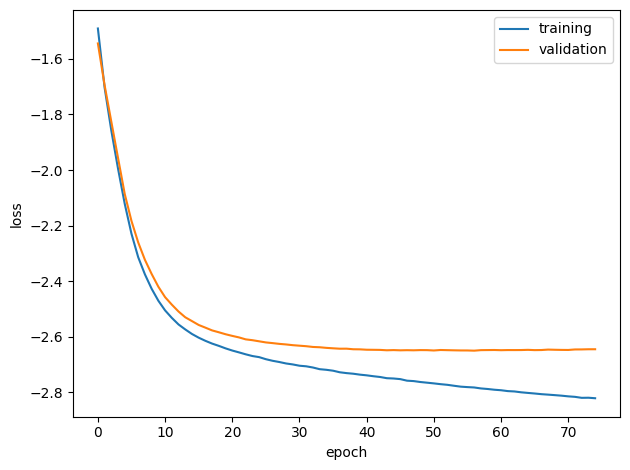

In [15]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(model.training_losses)), model.training_losses)
ax.plot(np.arange(len(model.validation_losses)), model.validation_losses)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend(['training','validation'])
fig.tight_layout()

In [16]:
evecs_SRV_unbiased = model.transform(traj_x.float()).cpu().detach().numpy()

In [17]:
dataset = pd.DataFrame(evecs_SRV_unbiased, columns=["TIC0", "TIC1", "TIC2"])
px.scatter(dataset, x="TIC1", y="TIC2", width=600, height=600)

In [18]:
print(dataset.max())
print(dataset.min())

TIC0    1.518877
TIC1    1.981122
TIC2    2.424743
dtype: float32
TIC0    0.679517
TIC1   -1.330376
TIC2   -2.310448
dtype: float32


In [19]:
class CV(torch.nn.Module):
    def __init__(self, model, idx):
        super().__init__()
        self.model = model
        self.idx = idx
        self.register_buffer("i_list_d", i_list_d)
        self.register_buffer("j_list_d", j_list_d)
        self.register_buffer("i_list_dih", i_list_dih)
        self.register_buffer("j_list_dih", j_list_dih)
        self.register_buffer("k_list_dih", k_list_dih)
        self.register_buffer("l_list_dih", l_list_dih)

    def compute_mic_dist(self, pos, box):
        d = pos[self.i_list_d, :] - pos[self.j_list_d, :]  # shape: [T, M, 3]
        d = d - box * torch.round(d / box)  # apply MIC
        return torch.norm(d, dim=-1)  # shape: [T, M]
    
    def compute_mic_angles(self, pos, box):
        # pos: [T, N, 3]
        # box: [T, 1, 3]
        # i, j, k: [M]
        
        # MIC vector: ri - rj
        v1 = pos[self.i_list_a, :] - pos[self.j_list_a, :]  # [T, M, 3]
        v1 = v1 - box * torch.round(v1 / box)

        # MIC vector: rk - rj
        v2 = pos[self.k_list_a, :] - pos[self.j_list_a, :]
        v2 = v2 - box * torch.round(v2 / box)

        # Normalize
        v1_norm = torch.nn.functional.normalize(v1, dim=-1)
        v2_norm = torch.nn.functional.normalize(v2, dim=-1)

        # Dot product and angle
        cos_theta = (v1_norm * v2_norm).sum(dim=-1).clamp(-1.0, 1.0)
        angles = torch.acos(cos_theta)  # [T, M], in radians

        return angles
    
    def compute_mic_dihedrals(self, pos, box):
        # pos: [T, N, 3]
        # box: [T, 1, 3] (broadcastable)
        # i, j, k, l: [M]

        # MIC vectors
        b1 = pos[self.j_list_dih, :] - pos[self.i_list_dih, :]
        b1 = b1 - box * torch.round(b1 / box)

        b2 = pos[self.k_list_dih, :] - pos[self.j_list_dih, :]
        b2 = b2 - box * torch.round(b2 / box)

        b3 = pos[self.l_list_dih, :] - pos[self.k_list_dih, :]
        b3 = b3 - box * torch.round(b3 / box)

        # Normalize b2 for later
        b2_norm = torch.nn.functional.normalize(b2, dim=-1)

        # Compute normals to the planes
        n1 = torch.cross(b1, b2, dim=-1)  # plane i-j-k
        n2 = torch.cross(b2, b3, dim=-1)  # plane j-k-l

        # Normalize
        n1 = torch.nn.functional.normalize(n1, dim=-1)
        n2 = torch.nn.functional.normalize(n2, dim=-1)

        # Compute cosine and sine terms
        cos_phi = (n1 * n2).sum(dim=-1).clamp(-1.0, 1.0)
        sin_phi = (torch.cross(n1, n2, dim=-1) * b2_norm).sum(dim=-1)

        # Final torsion angle
        dihedrals = torch.atan2(sin_phi, cos_phi)  # shape: [T, M], radians

        return dihedrals

    def forward(self, positions, boxvectors):
        """The forward method returns the energy computed from positions.

        Parameters
        ----------
        positions : torch.Tensor with shape (nparticles, 3)
           positions[i,k] is the position (in nanometers) of spatial dimension k of particle i

        Returns
        -------
        potential : torch.Scalar
           The potential energy (in kJ/mol)
        """
        boxsize = boxvectors.diag()
        feat_d = self.compute_mic_dist(positions, boxsize)
        feat_dih = self.compute_mic_dihedrals(positions, boxsize)
        feats = torch.concat([feat_d, feat_dih])
        evecs = self.model.transform(feats.view(1, -1))
        CV = evecs[0][self.idx]
        return CV

model_output_1 = CV(model, 1)
model_output_2 = CV(model, 2)

torch.jit.script(model_output_1).save('cv1.pt')
torch.jit.script(model_output_2).save('cv2.pt')